# Advanced Lane Lines - Perspective transformation

In this notebook the following points from the Project 4 Advanced Lane Lines are implemented:
* Apply a perspective transform to rectify binary image ("birds-eye view").
 

---
## Step 0: Import required libraries 

In [1]:
import pickle
import cv2
import glob
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from camera_calibration import undistortImage

## Step 1:  Udacity function: perspective transform for a calibration image 

In [2]:
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    img_undistorted = undistortImage(img, mtx, dist, plotImages=False)
    
    # 2) Convert to grayscale
    gray = cv2.cvtColor(img_undistorted, cv2.COLOR_BGR2GRAY)
    
    # 3) Find the chessboard corners
    print("Finding corners in calibration image")
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # 4) If corners found: 
    if ret == True:
        print("corners.size: {}".format(corners.size))
        print("len(corners): {}".format(len(corners)))
        
        # a) draw corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        
        # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
             #Note: you could pick any four of the detected corners 
             # as long as those four corners define a rectangle
             #One especially smart way to do this would be to use four well-chosen
             # corners that were automatically detected during the undistortion steps
             #We recommend using the automatic detection of corners in your code
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
         
        # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
        offset = 100
        img_size = (gray.shape[1], gray.shape[0])
        dst = np.float32([[offset, offset],
                         [img_size[0]-offset, offset],
                         [img_size[0]-offset, img_size[1]-offset],
                         [offset, img_size[1]-offset]])
        
        # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)

        # e) use cv2.warpPerspective() to warp your image to a top-down view
        warped = cv2.warpPerspective(img_undistorted, M, img_size, flags=cv2.INTER_LINEAR)
    else:
        print("Could not find chessboard corners!")
        M = None
        warped = np.copy(img) 
        
    return warped, M

## Step 2:  Apply a perspective transform on a calibration image 

Finding corners in calibration image
corners.size: 108
len(corners): 54


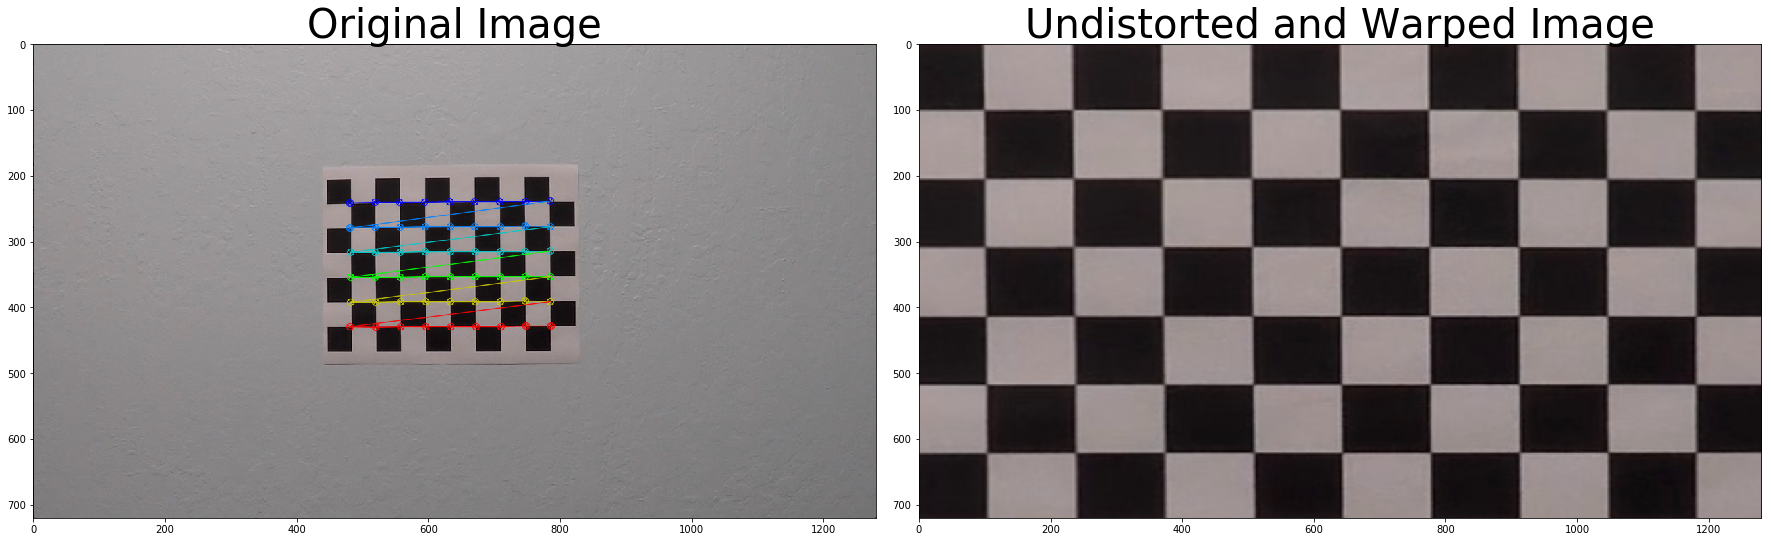

In [3]:
# Read in the saved camera matrix and distortion coefficients
ret, mtx, dist, rvecs, tvecs = pickle.load( open( "./camera_cal/camera_calibration_results.p", "rb" ) )

# Read in an image
calibrationImage = cv2.imread('./camera_cal/calibration6.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

from_front, _ = corners_unwarp(calibrationImage, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(calibrationImage)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(from_front)
ax2.set_title('Undistorted and Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 

## Step 3: Find points for perspective transformation

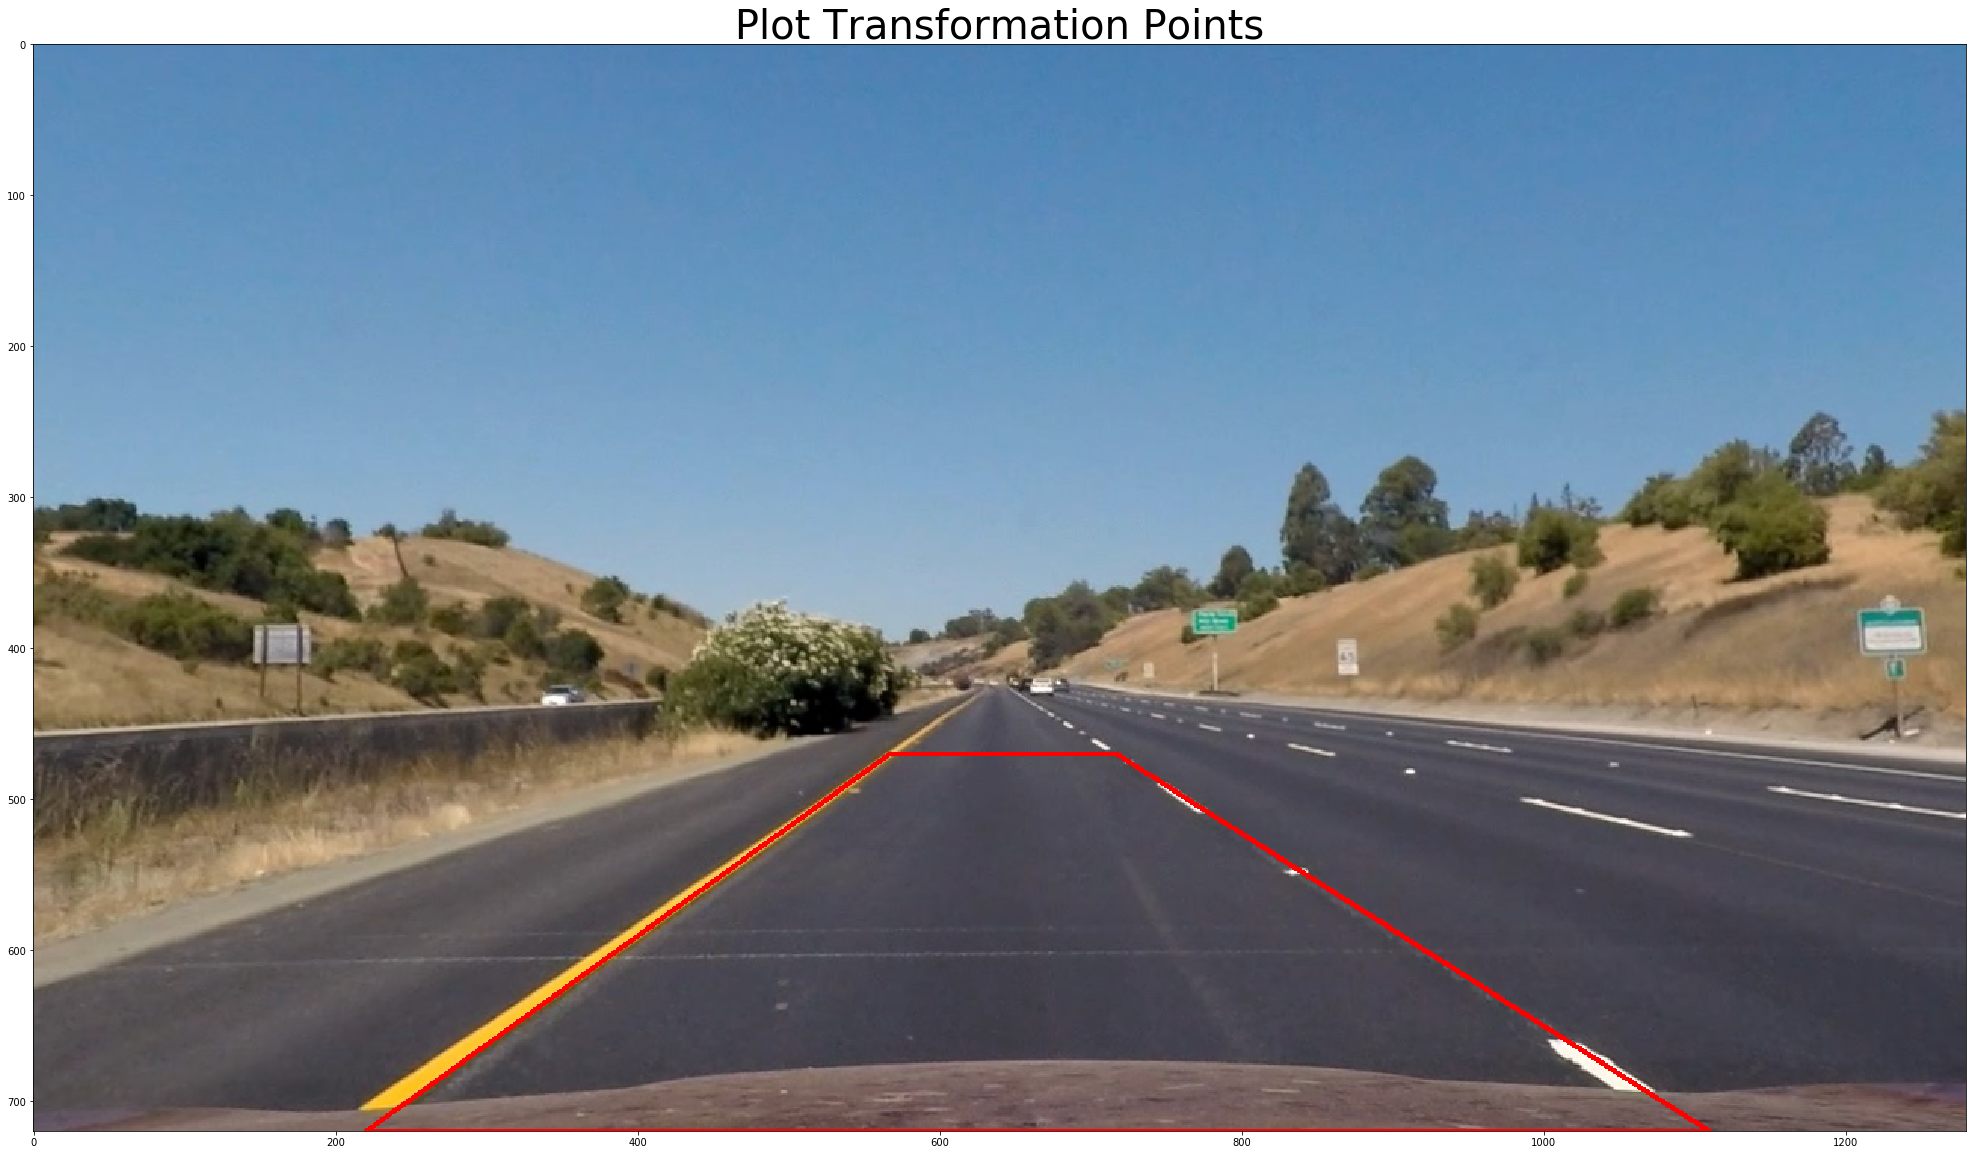

In [4]:
# Read in an image
originalTestImage = cv2.cvtColor(cv2.imread('./test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)
undistImage = cv2.undistort(originalTestImage, mtx, dist, None, mtx)

copyImage = undistImage.copy()

bottomY = 720
topY = 470
    
left1 = (220, bottomY)
left1_x, left1_y = left1
left2 = (567, topY)
left2_x, left2_y = left2

right1 = (717, topY)
right1_x, right1_y = right1

right2 = (1110, bottomY)
right2_x, right2_y = right2

color = [255, 0, 0]
w = 2
cv2.line(copyImage, left1, left2, color, w)
cv2.line(copyImage, left2, right1, color, w)
cv2.line(copyImage, right1, right2, color, w)
cv2.line(copyImage, right2, left1, color, w)
fig, ax = plt.subplots(figsize=(40, 20))
ax.set_title('Plot Transformation Points', fontsize=40)
ax.imshow(copyImage) 

## Step 4: Perform perspective transformation and check birds-eye view

In [5]:
def warpImage2birdsEyeView(img, img_size, perspective_M):

    # Use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, perspective_M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

def getPerspectiveTransform(img_size):
    
    src = np.float32([[567, 470],[717, 470],[1110, 720],[200, 720]])

    offset, mult = 100, 3    
    dst = np.float32([[mult * offset, offset],
                     [img_size[0] - mult * offset, offset],
                     [img_size[0] - mult * offset, img_size[1]],
                     [mult * offset, img_size[1]]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)

    return src, dst, M, M_inv

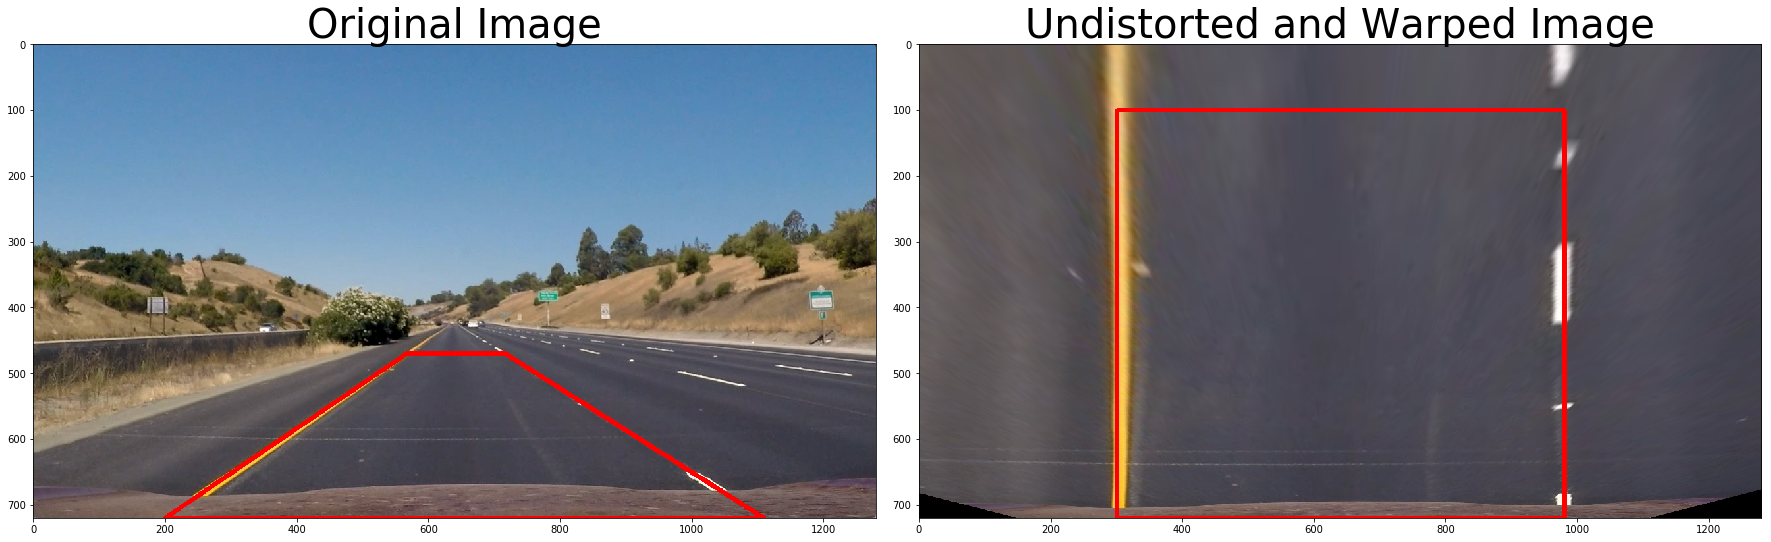

In [6]:
ret, mtx, dist, rvecs, tvecs = pickle.load( open( "./camera_cal/camera_calibration_results.p", "rb" ) )

originalTestImage = cv2.cvtColor(cv2.imread('./test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)                                 
undistImage = undistortImage(originalTestImage, mtx, dist, plotImages=False)
imageSize = (undistImage.shape[1], undistImage.shape[0]) 
src, dst, perspective_M, perspective_M_inv = getPerspectiveTransform(imageSize)
bidsEyeImage = warpImage2birdsEyeView(originalTestImage, imageSize, perspective_M)

pts = np.array(src, np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(originalTestImage, [pts], True, (255, 0, 0), 5)

pts = np.array(dst, np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(bidsEyeImage, [pts], True, (255, 0, 0), 5)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(originalTestImage)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(bidsEyeImage)
ax2.set_title('Undistorted and Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 

## Step 5: Test perform perspective transformation and top down view on straight and curve images

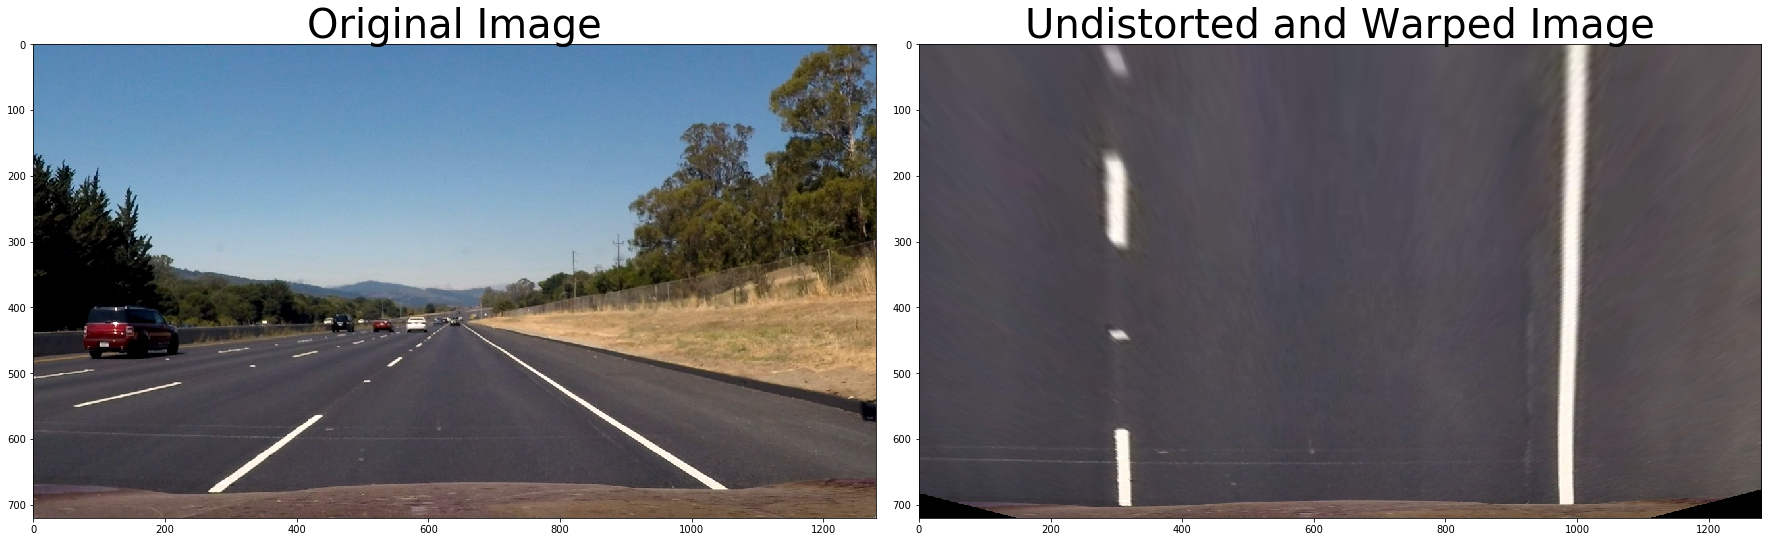

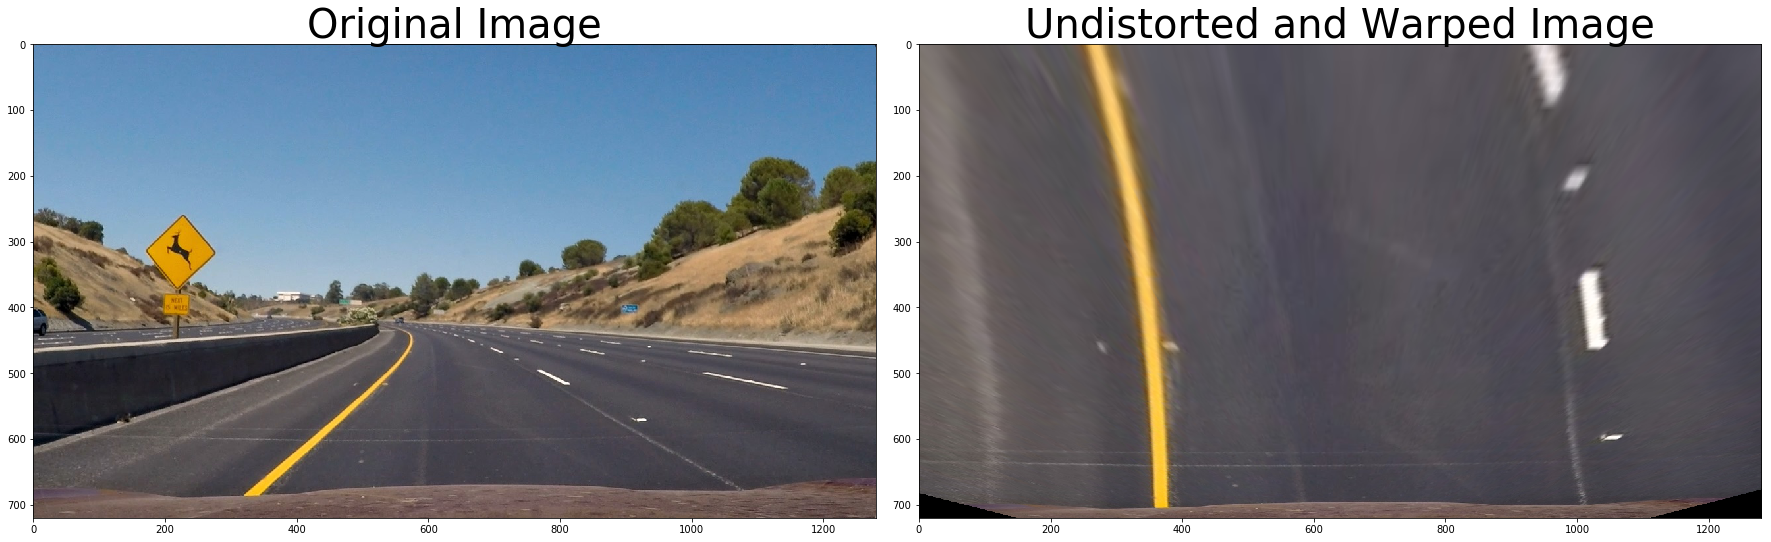

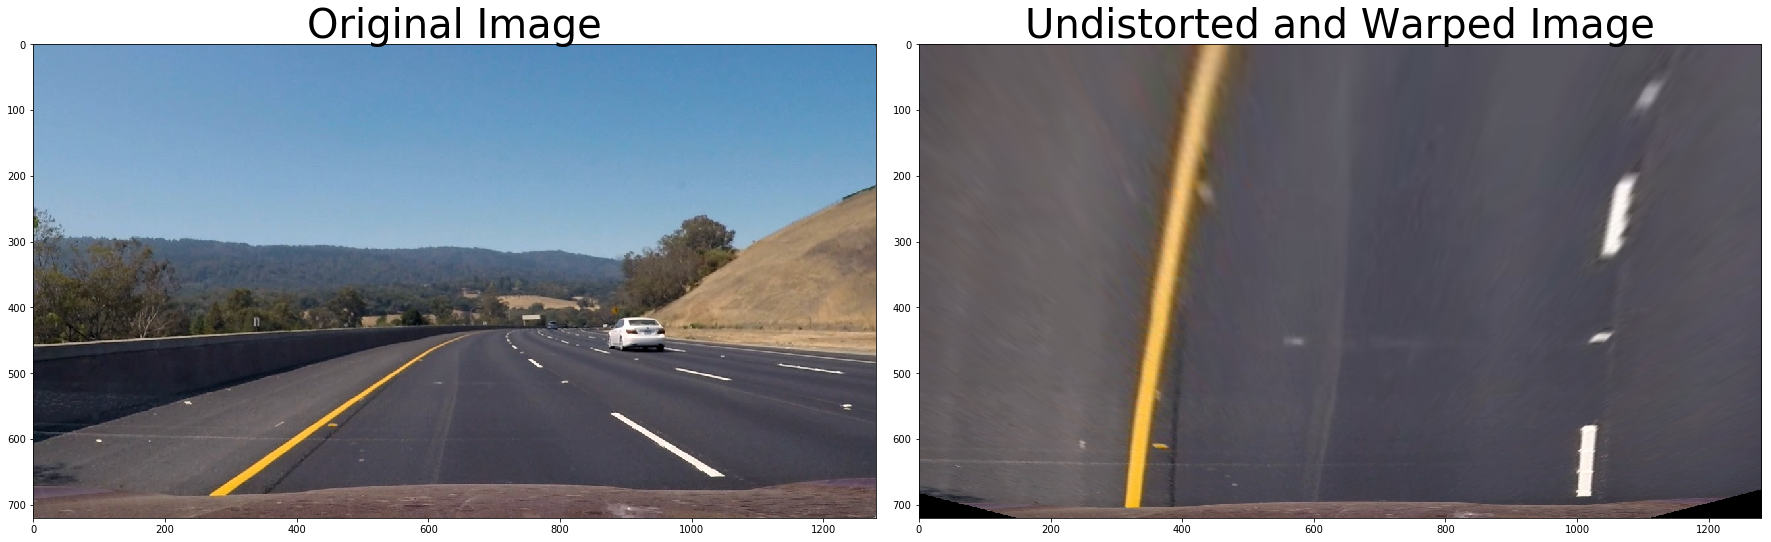

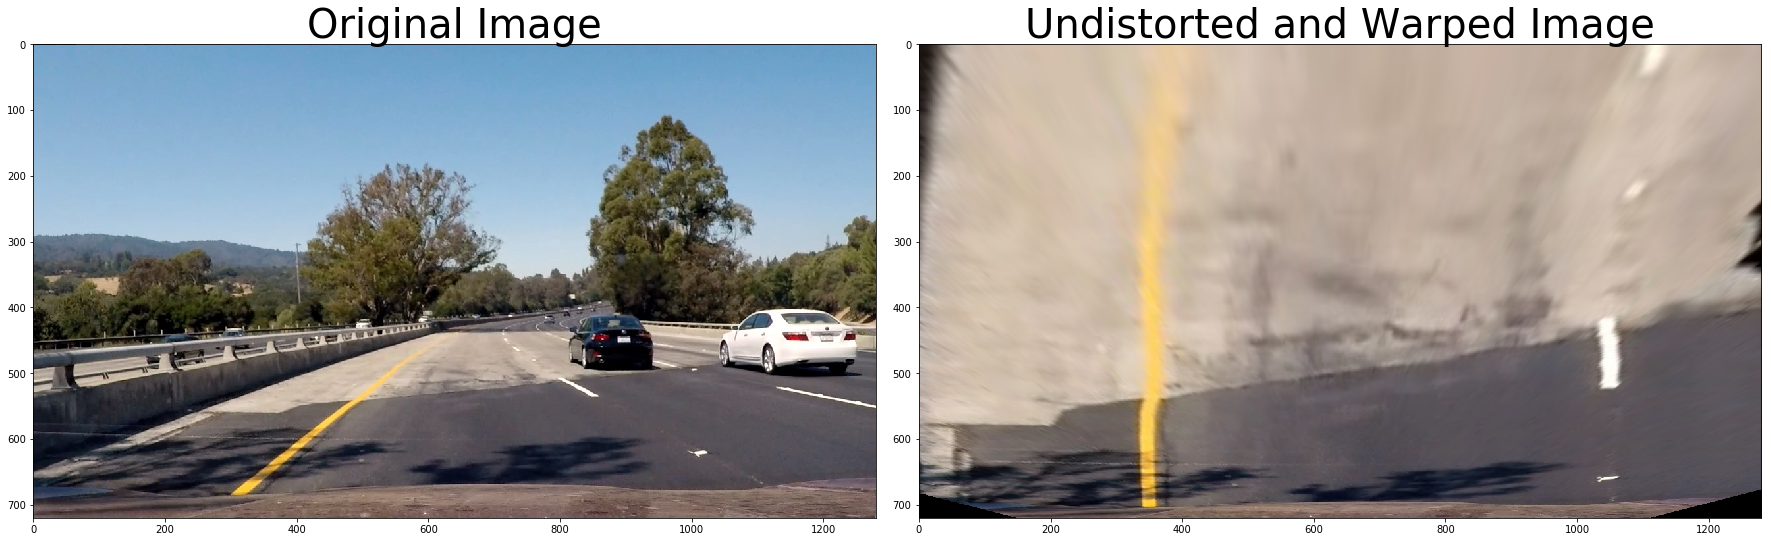

In [7]:
# test2.jpg
originalTestImage = cv2.cvtColor(cv2.imread('./test_images/straight_lines2.jpg'), cv2.COLOR_BGR2RGB)
undistImage = undistortImage(originalTestImage, mtx, dist, plotImages=False)
bidsEyeImage = warpImage2birdsEyeView(originalTestImage, imageSize, perspective_M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(originalTestImage)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(bidsEyeImage)
ax2.set_title('Undistorted and Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# test2.jpg
originalTestImage = cv2.cvtColor(cv2.imread('./test_images/test2.jpg'), cv2.COLOR_BGR2RGB)
undistImage = undistortImage(originalTestImage, mtx, dist, plotImages=False)
bidsEyeImage = warpImage2birdsEyeView(originalTestImage, imageSize, perspective_M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(originalTestImage)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(bidsEyeImage)
ax2.set_title('Undistorted and Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# test3.jpg
originalTestImage = cv2.cvtColor(cv2.imread('./test_images/test3.jpg'), cv2.COLOR_BGR2RGB)
undistImage = undistortImage(originalTestImage, mtx, dist, plotImages=False)
bidsEyeImage = warpImage2birdsEyeView(originalTestImage, imageSize, perspective_M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(originalTestImage)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(bidsEyeImage)
ax2.set_title('Undistorted and Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 

# test4.jpg
originalTestImage = cv2.cvtColor(cv2.imread('./test_images/test4.jpg'), cv2.COLOR_BGR2RGB)
undistImage = undistortImage(originalTestImage, mtx, dist, plotImages=False)
bidsEyeImage = warpImage2birdsEyeView(originalTestImage, imageSize, perspective_M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(originalTestImage)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(bidsEyeImage)
ax2.set_title('Undistorted and Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 